# Trading Strategies powered by Machine Learning - Logistic Regression

## Logistic Regression with scikit-learn - a Simple Introduction

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [4]:
from backtesting import Strategy

## Getting the Data

In [5]:
XAUUSD = load_data()

In [6]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [7]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


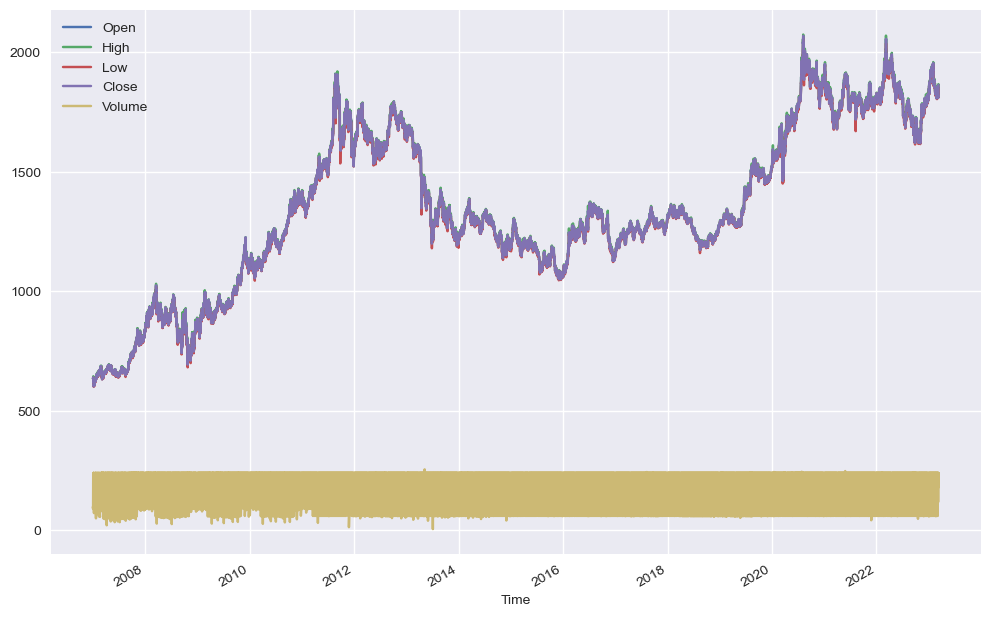

In [8]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [9]:
class Logistic_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [10]:
strategy = Logistic_Regression
account_size = 1000
folder_ML_Strategy = 'Logistic Regression'

In [11]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def Prepare(self, lags=5):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["return_signal"] = data["returns"].shift(-1)
        data.dropna(inplace=True)
        data["direction"] = np.sign(data.return_signal)

        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        lm = LogisticRegression(C=1e6, max_iter=100000, multi_class="ovr")
        lm.fit(data[cols], data['direction'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data

    def Predict(self, lags=5):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        data.dropna(inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data

    def Backtest(self, data, account_size=1000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin= 1/100)
        result = backtest.run()
        return result


    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        
        self.Predict()
        result_test = self.Backtest(self.data_test)
        

        return result_train, result_test

## TF D1

In [12]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [13]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [14]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [15]:
train

Start                     2007-01-08 00:00:00
End                       2019-12-30 00:00:00
Duration                   4739 days 00:00:00
Exposure Time [%]                   99.950556
Equity Final [$]                     2069.143
Equity Peak [$]                       2179.32
Return [%]                           106.9143
Buy & Hold Return [%]              148.689509
Return (Ann.) [%]                    4.634156
Volatility (Ann.) [%]               12.392641
Sharpe Ratio                         0.373944
Sortino Ratio                        0.548444
Calmar Ratio                         0.159009
Max. Drawdown [%]                  -29.143953
Avg. Drawdown [%]                   -2.013402
Max. Drawdown Duration     2643 days 00:00:00
Avg. Drawdown Duration       59 days 00:00:00
# Trades                                  683
Win Rate [%]                        57.833089
Best Trade [%]                       8.265639
Worst Trade [%]                    -13.395827
Avg. Trade [%]                    

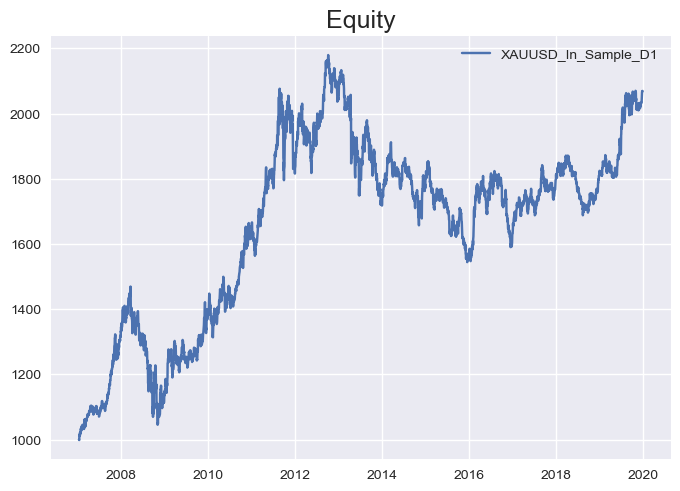

In [16]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [17]:
test

Start                     2020-01-08 00:00:00
End                       2023-03-10 00:00:00
Duration                   1157 days 00:00:00
Exposure Time [%]                   99.796954
Equity Final [$]                      991.401
Equity Peak [$]                      1413.591
Return [%]                            -0.8599
Buy & Hold Return [%]               19.648007
Return (Ann.) [%]                   -0.220702
Volatility (Ann.) [%]               25.154394
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -53.261092
Avg. Drawdown [%]                   -6.457275
Max. Drawdown Duration      945 days 00:00:00
Avg. Drawdown Duration       81 days 00:00:00
# Trades                                  127
Win Rate [%]                        53.543307
Best Trade [%]                       6.319892
Worst Trade [%]                     -7.732588
Avg. Trade [%]                    

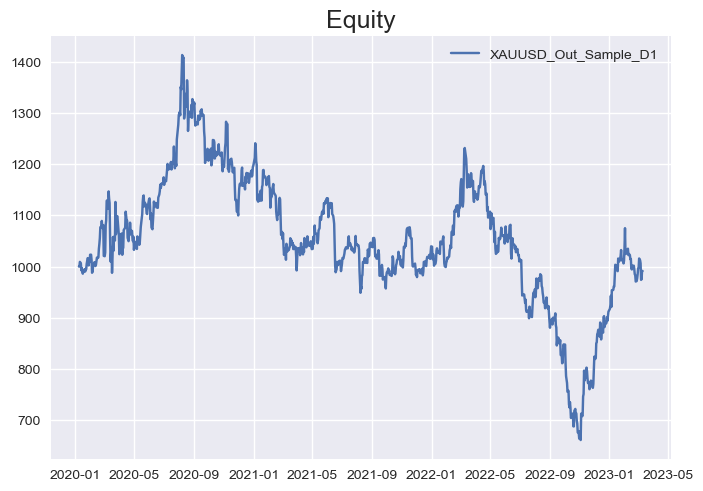

In [18]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [19]:
filename_train = f'result_{TF}_In_Sample.csv'

In [20]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [21]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [22]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [23]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [24]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [25]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [26]:
train

Start                     2007-01-02 00:00:00
End                       2019-12-31 16:00:00
Duration                   4746 days 16:00:00
Exposure Time [%]                   99.990414
Equity Final [$]                     2809.707
Equity Peak [$]                      3077.977
Return [%]                           180.9707
Buy & Hold Return [%]              138.448093
Return (Ann.) [%]                    6.652005
Volatility (Ann.) [%]                9.575224
Sharpe Ratio                          0.69471
Sortino Ratio                        1.094441
Calmar Ratio                         0.278316
Max. Drawdown [%]                  -23.900893
Avg. Drawdown [%]                   -0.864508
Max. Drawdown Duration     3073 days 12:00:00
Avg. Drawdown Duration       16 days 08:00:00
# Trades                                 6580
Win Rate [%]                        60.334347
Best Trade [%]                       6.728522
Worst Trade [%]                    -13.515261
Avg. Trade [%]                    

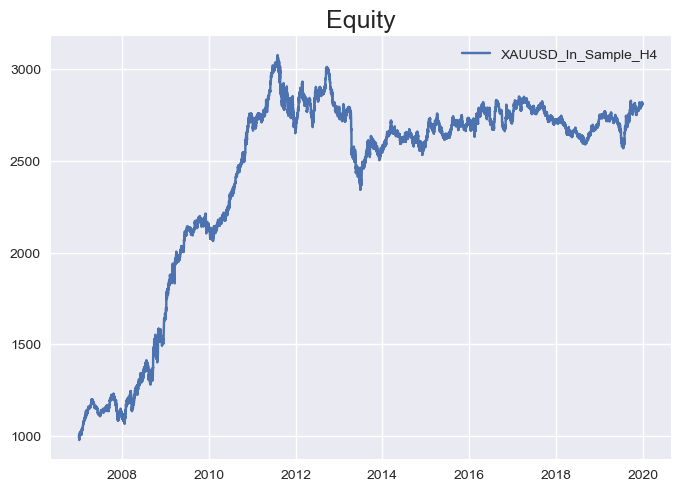

In [27]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [28]:
test

Start                     2020-01-02 20:00:00
End                       2023-03-10 16:00:00
Duration                   1162 days 20:00:00
Exposure Time [%]                   99.960777
Equity Final [$]                      976.675
Equity Peak [$]                      1268.772
Return [%]                            -2.3325
Buy & Hold Return [%]               21.937846
Return (Ann.) [%]                    -0.59896
Volatility (Ann.) [%]               25.107201
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -32.197589
Avg. Drawdown [%]                   -3.393474
Max. Drawdown Duration      967 days 16:00:00
Avg. Drawdown Duration       34 days 01:00:00
# Trades                                 1589
Win Rate [%]                        60.604154
Best Trade [%]                       3.305444
Worst Trade [%]                     -4.650669
Avg. Trade [%]                    

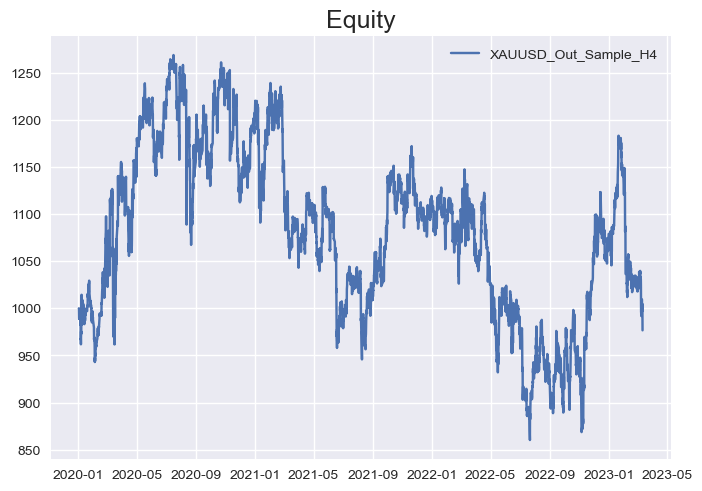

In [29]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [30]:
filename_train = f'result_{TF}_In_Sample.csv'

In [31]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [32]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [33]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [34]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [35]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [36]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [37]:
train

Start                     2007-01-01 06:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 14:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                     3239.042
Equity Peak [$]                      3450.639
Return [%]                           223.9042
Buy & Hold Return [%]              138.749634
Return (Ann.) [%]                     7.57284
Volatility (Ann.) [%]                10.71464
Sharpe Ratio                         0.706775
Sortino Ratio                        1.074595
Calmar Ratio                         0.303677
Max. Drawdown [%]                  -24.937178
Avg. Drawdown [%]                   -0.480743
Max. Drawdown Duration     1274 days 05:00:00
Avg. Drawdown Duration        6 days 13:00:00
# Trades                                28161
Win Rate [%]                        66.560136
Best Trade [%]                       3.447623
Worst Trade [%]                     -9.726597
Avg. Trade [%]                    

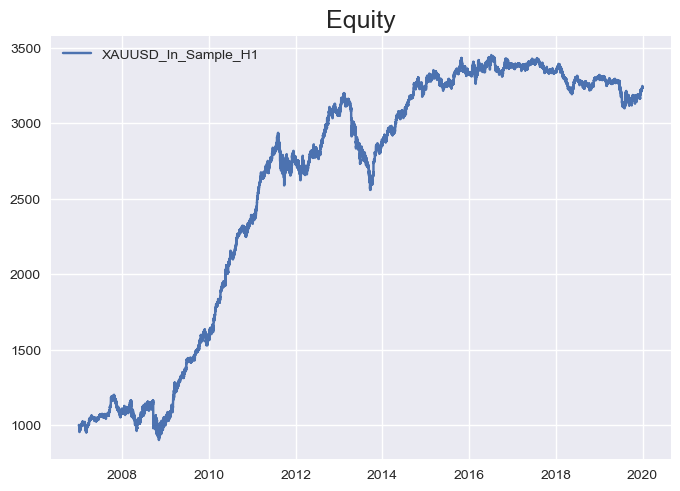

In [38]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [39]:
test

Start                     2020-01-02 05:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 12:00:00
Exposure Time [%]                   99.989394
Equity Final [$]                     1891.357
Equity Peak [$]                      2239.921
Return [%]                            89.1357
Buy & Hold Return [%]               22.623102
Return (Ann.) [%]                   17.641634
Volatility (Ann.) [%]               19.679653
Sharpe Ratio                          0.89644
Sortino Ratio                        1.611913
Calmar Ratio                         0.706989
Max. Drawdown [%]                  -24.953201
Avg. Drawdown [%]                   -1.022572
Max. Drawdown Duration      424 days 00:00:00
Avg. Drawdown Duration        5 days 00:00:00
# Trades                                 6640
Win Rate [%]                        65.843373
Best Trade [%]                       3.292779
Worst Trade [%]                     -4.993373
Avg. Trade [%]                    

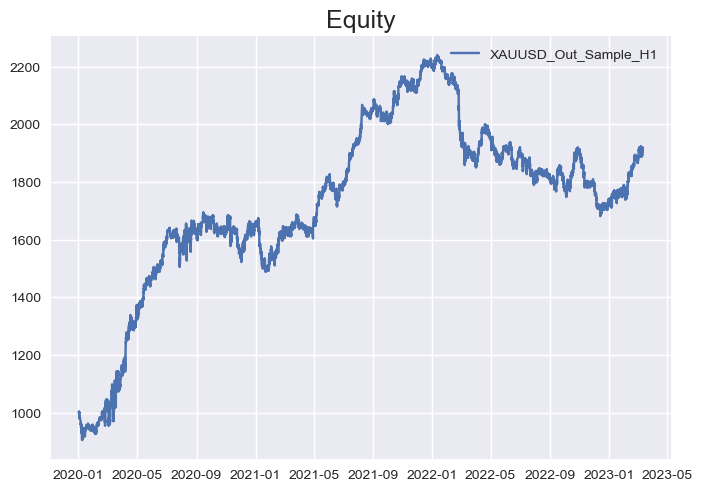

In [40]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [41]:
filename_train = f'result_{TF}_In_Sample.csv'

In [42]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [43]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [44]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [45]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [46]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [47]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [48]:
train

Start                     2007-01-01 03:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 18:00:00
Exposure Time [%]                    99.99873
Equity Final [$]                     3958.234
Equity Peak [$]                      3960.911
Return [%]                           295.8234
Buy & Hold Return [%]              138.820778
Return (Ann.) [%]                    8.910851
Volatility (Ann.) [%]                8.975684
Sharpe Ratio                         0.992777
Sortino Ratio                        1.569299
Calmar Ratio                         0.513943
Max. Drawdown [%]                  -17.338207
Avg. Drawdown [%]                   -0.321295
Max. Drawdown Duration      591 days 07:00:00
Avg. Drawdown Duration        3 days 08:07:00
# Trades                                55479
Win Rate [%]                        66.628815
Best Trade [%]                       3.226737
Worst Trade [%]                     -9.578469
Avg. Trade [%]                    

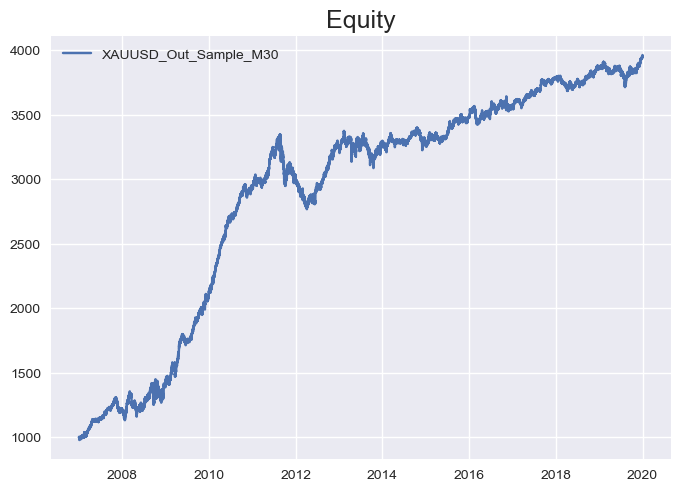

In [49]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [50]:
test

Start                     2020-01-02 02:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 15:30:00
Exposure Time [%]                   99.994696
Equity Final [$]                     2856.169
Equity Peak [$]                      2863.366
Return [%]                           185.6169
Buy & Hold Return [%]                22.67717
Return (Ann.) [%]                   30.410968
Volatility (Ann.) [%]               19.687616
Sharpe Ratio                         1.544675
Sortino Ratio                        3.193285
Calmar Ratio                         1.495663
Max. Drawdown [%]                  -20.332763
Avg. Drawdown [%]                   -0.535926
Max. Drawdown Duration      162 days 02:00:00
Avg. Drawdown Duration        2 days 01:36:00
# Trades                                13223
Win Rate [%]                        66.739772
Best Trade [%]                       1.917718
Worst Trade [%]                     -4.836667
Avg. Trade [%]                    

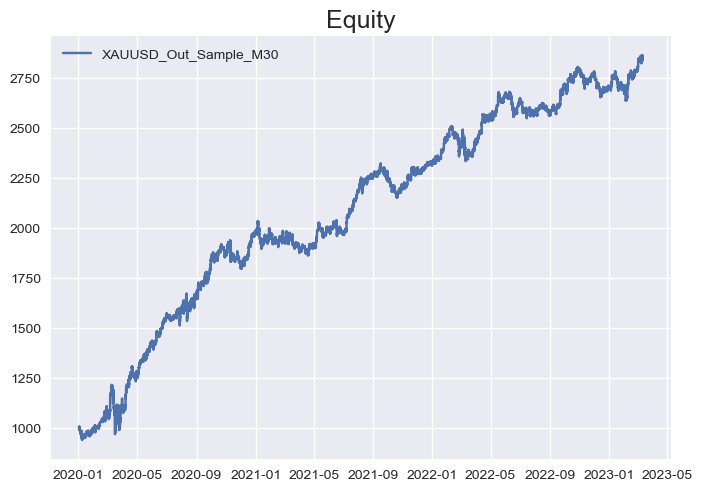

In [51]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [52]:
filename_train = f'result_{TF}_In_Sample.csv'

In [53]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [54]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [55]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [56]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [57]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [58]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [59]:
train

Start                     2014-09-23 14:30:00
End                       2019-12-31 21:30:00
Duration                   1925 days 07:00:00
Exposure Time [%]                   99.998394
Equity Final [$]                      2053.91
Equity Peak [$]                      2070.372
Return [%]                            105.391
Buy & Hold Return [%]               24.218093
Return (Ann.) [%]                    11.58382
Volatility (Ann.) [%]               11.565993
Sharpe Ratio                         1.001541
Sortino Ratio                        1.645581
Calmar Ratio                         0.719506
Max. Drawdown [%]                  -16.099682
Avg. Drawdown [%]                   -0.333746
Max. Drawdown Duration      287 days 23:30:00
Avg. Drawdown Duration        2 days 05:43:00
# Trades                                43924
Win Rate [%]                        67.125034
Best Trade [%]                       2.403406
Worst Trade [%]                      -4.47118
Avg. Trade [%]                    

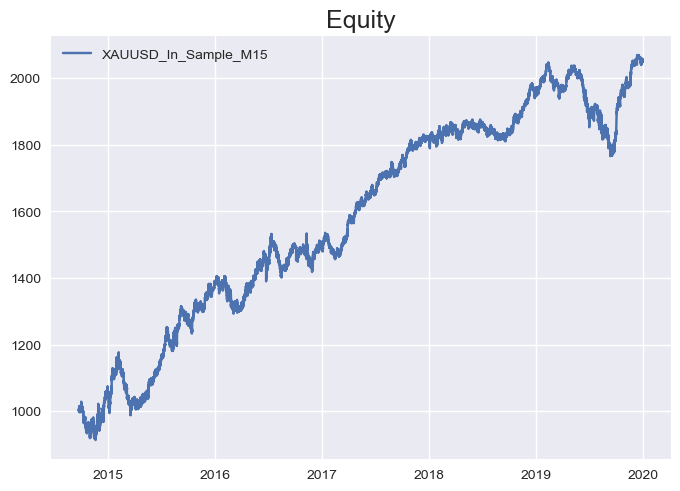

In [60]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [61]:
test

Start                     2020-01-02 00:30:00
End                       2023-03-10 17:45:00
Duration                   1163 days 17:15:00
Exposure Time [%]                   99.997348
Equity Final [$]                     2955.937
Equity Peak [$]                      3163.112
Return [%]                           195.5937
Buy & Hold Return [%]               22.768468
Return (Ann.) [%]                   31.785695
Volatility (Ann.) [%]               17.255925
Sharpe Ratio                         1.842016
Sortino Ratio                        4.053911
Calmar Ratio                         2.131931
Max. Drawdown [%]                  -14.909342
Avg. Drawdown [%]                   -0.382843
Max. Drawdown Duration      244 days 06:30:00
Avg. Drawdown Duration        1 days 11:10:00
# Trades                                26578
Win Rate [%]                        66.961397
Best Trade [%]                       2.054545
Worst Trade [%]                     -5.118639
Avg. Trade [%]                    

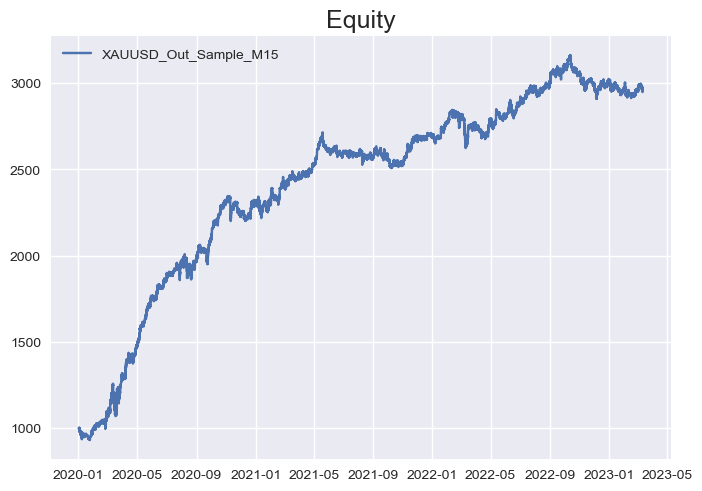

In [62]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [63]:
filename_train = f'result_{TF}_In_Sample.csv'

In [64]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [65]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [66]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [67]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [68]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [69]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [70]:
train

Start                     2020-05-15 11:40:00
End                       2022-12-30 21:50:00
Duration                    959 days 10:10:00
Exposure Time [%]                   99.998928
Equity Final [$]                     5198.408
Equity Peak [$]                      5263.418
Return [%]                           419.8408
Buy & Hold Return [%]                5.290959
Return (Ann.) [%]                   66.182735
Volatility (Ann.) [%]               15.797062
Sharpe Ratio                          4.18956
Sortino Ratio                       15.554754
Calmar Ratio                         8.755142
Max. Drawdown [%]                   -7.559299
Avg. Drawdown [%]                   -0.129512
Max. Drawdown Duration       43 days 00:40:00
Avg. Drawdown Duration        0 days 07:11:00
# Trades                                76218
Win Rate [%]                        64.774725
Best Trade [%]                          1.128
Worst Trade [%]                     -3.170082
Avg. Trade [%]                    

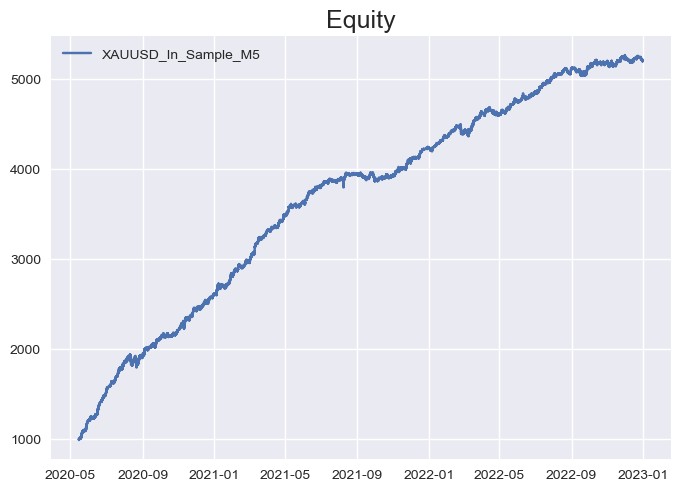

In [71]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [72]:
test

Start                     2023-01-02 23:30:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:25:00
Exposure Time [%]                   99.985063
Equity Final [$]                     1139.075
Equity Peak [$]                      1170.342
Return [%]                            13.9075
Buy & Hold Return [%]                1.999557
Return (Ann.) [%]                   75.656589
Volatility (Ann.) [%]               35.617708
Sharpe Ratio                         2.124129
Sortino Ratio                          6.5911
Calmar Ratio                        10.164525
Max. Drawdown [%]                     -7.4432
Avg. Drawdown [%]                   -0.329524
Max. Drawdown Duration       30 days 06:45:00
Avg. Drawdown Duration        0 days 10:54:00
# Trades                                 5377
Win Rate [%]                        65.017668
Best Trade [%]                        0.46321
Worst Trade [%]                     -1.772775
Avg. Trade [%]                    

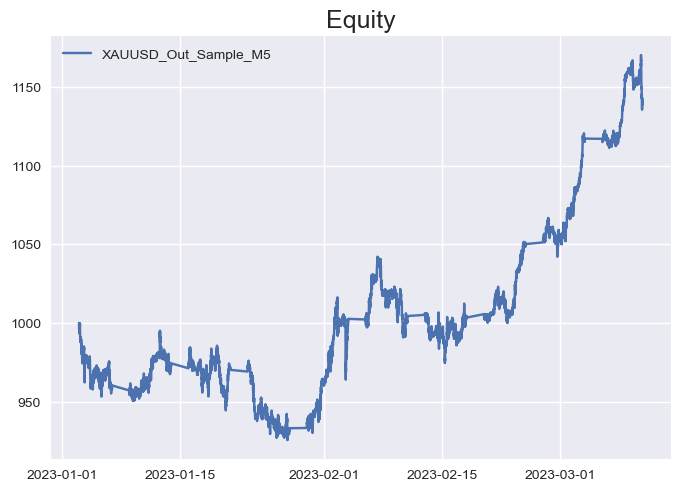

In [73]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [74]:
filename_train = f'result_{TF}_In_Sample.csv'

In [75]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [76]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [77]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [78]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [79]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF)

In [80]:
train , test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_10976\3803460819.py:71: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [81]:
train

Start                     2022-08-16 23:19:00
End                       2022-12-30 21:57:00
Duration                    135 days 22:38:00
Exposure Time [%]                   99.998497
Equity Final [$]                     1428.752
Equity Peak [$]                      1516.318
Return [%]                            42.8752
Buy & Hold Return [%]                  2.6722
Return (Ann.) [%]                  115.572924
Volatility (Ann.) [%]               46.572734
Sharpe Ratio                         2.481558
Sortino Ratio                       11.583358
Calmar Ratio                         12.41236
Max. Drawdown [%]                   -9.311116
Avg. Drawdown [%]                   -0.167737
Max. Drawdown Duration       28 days 07:35:00
Avg. Drawdown Duration        0 days 03:57:00
# Trades                                43684
Win Rate [%]                        65.644172
Best Trade [%]                       1.272465
Worst Trade [%]                     -1.515421
Avg. Trade [%]                    

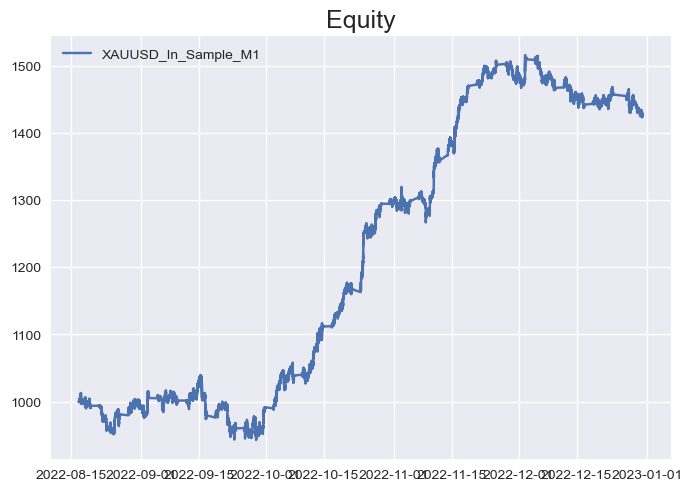

In [82]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [83]:
test

Start                     2023-01-02 23:08:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:51:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1054.533
Equity Peak [$]                      1059.782
Return [%]                             5.4533
Buy & Hold Return [%]                1.903539
Return (Ann.) [%]                   29.103545
Volatility (Ann.) [%]                39.14507
Sharpe Ratio                         0.743479
Sortino Ratio                        1.502492
Calmar Ratio                         1.768599
Max. Drawdown [%]                  -16.455701
Avg. Drawdown [%]                     -0.3523
Max. Drawdown Duration       55 days 02:58:00
Avg. Drawdown Duration        0 days 13:28:00
# Trades                                21718
Win Rate [%]                        65.655217
Best Trade [%]                       0.506454
Worst Trade [%]                      -0.86035
Avg. Trade [%]                    

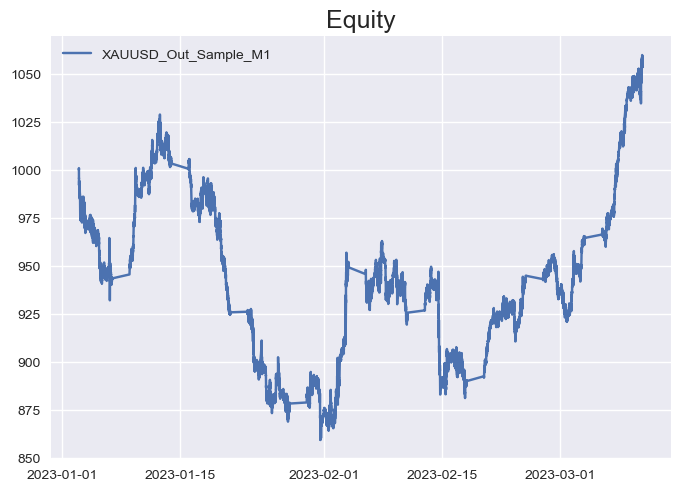

In [84]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [85]:
filename_train = f'result_{TF}_In_Sample.csv'

In [86]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')